In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
import geopandas as gpd
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException
import pickle
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx

In [ ]:

address = "https://mymetdata.met.gov.my/shop/product/9/records-of-daily-rainfall-amount-08-00-08-00-mst"
driver = webdriver.Chrome(service=Service("../webdriver/chromedriver.exe"))
driver.get(address)
sel_state = Select(driver.find_element("id","listState"))
states = [i.text for i in sel_state.options]
locations = []
for state in states[1:]:
    sel_state.select_by_visible_text(state)
    sleep(1)
    element = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.ID, "listDistrict")))
    sel_district = Select(element)
    districts = [i.text for i in sel_district.options][1:]
    for district in districts:
        sel_district.select_by_visible_text(district)
        sleep(1)
        element = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, "listStation")))
        sel_station = Select(element)
        stations = [i.text for i in sel_station.options][1:]
        for station in stations:
            sel_station.select_by_visible_text(station)
            locations.append(
                {'state':state,
                'district':district,
                'station':station,})

driver.close()
# with open('serialized/rain_locs.pkl.pkl','wb') as file:
    # pickle.dump(locations,file)

In [ ]:
address = "https://mymetdata.met.gov.my/shop/product/9/records-of-daily-rainfall-amount-08-00-08-00-mst"
driver = webdriver.Chrome(service=Service("../webdriver/chromedriver.exe"))
driver.get(address)

with open('serialized/rain_locs.pkl','rb') as file:
    locations = pickle.load(file)
    
location_datas = []
for location in locations[194:]:
    counter = 0
    while counter < 5:
        try:
            state = location['state']
            district = location['district']
            station = location['station']
            # select state
            sel_state = Select(driver.find_element("id","listState"))
            sel_state.select_by_visible_text(state)
            # select district
            element = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.ID, "listDistrict")))
            while True:
                try:
                    sel_district = Select(element)
                    sel_district.select_by_visible_text(district)
                    break
                except NotImplementedError:
                    sleep(0.05)
            # select station
            element = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.ID, "listStation")))
            sel_station = Select(element)
            sel_station.select_by_visible_text(station)
            element = WebDriverWait(driver, 2).until(
                EC.element_to_be_clickable((By.XPATH,'//*[@id="link-show-map"]/a')))
            element.click()
            element = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH,'//*[@id="show-map-lat-val"]')))
            latitude = element.text
            longitude = driver.find_element(By.XPATH,'//*[@id="show-map-long-val"]').text
            elevation = driver.find_element(By.XPATH,'//*[@id="show-map-elevation-val"]').text
            element = driver.find_element(By.XPATH,'//*[@id="modalShowMap"]/div/div/button')
            element.click()
            driver.refresh()
            location['latitude'] = latitude
            location['longitude'] = longitude
            location['elevation'] = elevation
            location_datas.append(location)
            break
        except TimeoutException:
            driver.refresh()
            counter += 1
            location['latitude'] = None
            location['longitude'] = None
            location['elevation'] = None
            location_datas.append(location)

driver.close()
# with open('serialized/rain_loc_datas2.pkl','wb') as file:
#     pickle.dump(location_datas,file)

In [2]:
with open('serialized/rain_locs.pkl','rb') as file:
    locations = pickle.load(file)

with open('serialized/rain_loc_datas.pkl','rb') as file:
    location_datas = pickle.load(file)

with open('serialized/rain_loc_datas2.pkl','rb') as file:
    location_datas2 = pickle.load(file)
    
len(locations),len(location_datas + location_datas2)

(387, 401)

In [3]:
df = pd.DataFrame(location_datas + location_datas2)
df = df.drop_duplicates()
df = df.dropna()
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['elevation'] = df['elevation']\
        .str.replace(" meter","")\
        .str.replace(",","")\
        .str.replace("-","0")\
        .str.replace("meter","0")\
        .str.replace(" m","")\
        .astype(float)
df.loc[df['station']=='FELDA MENGKARAK 1','longitude'] = 102.299167

In [4]:
# with open('serialized/df_rain_locs.pkl','wb') as file:
#     pickle.dump(df,file)

In [5]:
with open('serialized/df_rain_locs.pkl','rb') as file:
    df = pickle.load(file)

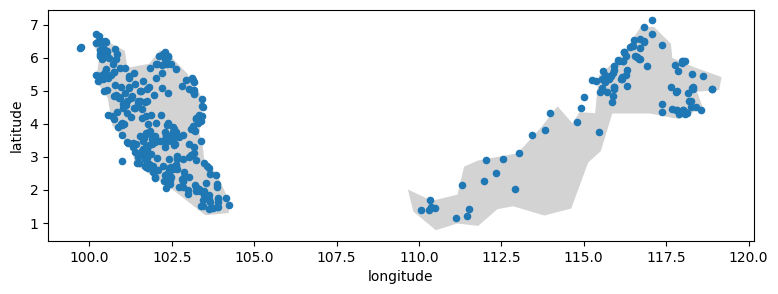

In [6]:
# initialize an axis
fig, ax = plt.subplots(figsize=(10,3))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "Malaysia"].plot(color="lightgrey",
                                                 ax=ax)
# plot points
df.plot(x="longitude", y="latitude", kind="scatter", ax=ax)
# add grid
plt.show()

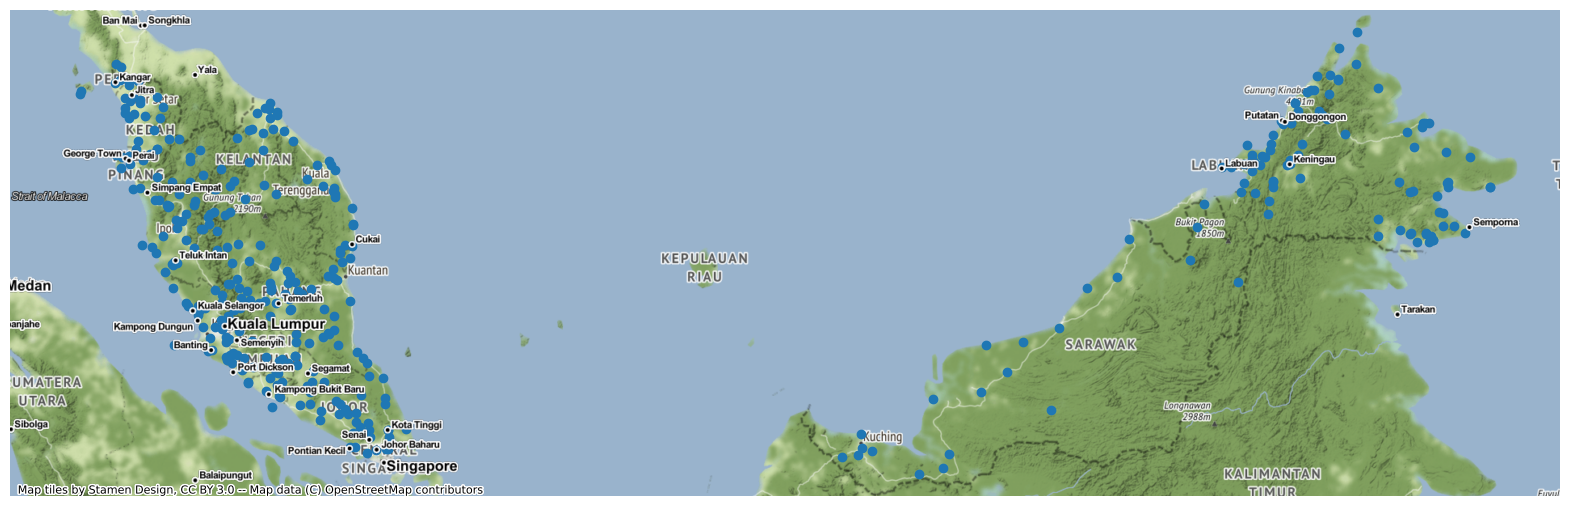

In [7]:
geometry = [Point(xy) for xy in zip(df.longitude,df.latitude)]
gdf = GeoDataFrame(df,crs="EPSG:4326",geometry=geometry)
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(20,10))
cx.add_basemap(ax)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.set_axis_off()